<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from tslearn.datasets import UCR_UEA_datasets
from sklearn import svm
import signature_features
from signature_features import *
import utils
from utils import *
import experiments
from experiments import * 
from sklearn.metrics import accuracy_score
# import gpflow
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

In [105]:
data_loader = UCR_UEA_datasets()
dict_acc = data_loader.baseline_accuracy(list_datasets=["ACSF1"])
dict_acc

{}

In [58]:
data_loader = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset("InlineSkate")

(100, 1882, 1)


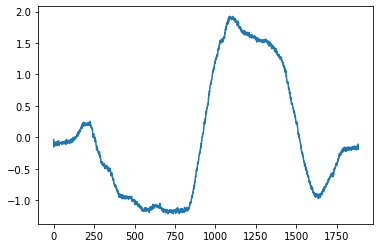

In [104]:
print(X_train.shape)
plt.plot(X_train[0])
plt.show()


In [93]:
# rescale
# scaler = StandardScaler()
# scaler.fit(np.concatenate(X_train, axis=0))
# X_train = [scaler.transform(x) for x in X_train]
# X_test = [scaler.transform(x) for x in X_test]
X_aug_train =  np.concatenate([np.concatenate(np.array_split(e[None,:-2,:],20,axis=1))[None,:,:,:] for e in X_train])
X_aug_test =  np.concatenate([np.concatenate(np.array_split(e[None,:-2,:], 20,axis=1))[None,:,:,:] for e in X_test])

# X_aug_train = X_train[:,None,:,:]
# X_aug_test = X_test[:,None,:,:]

# X_aug_train, X_aug_test = random_subsampling(X_train,X_test,300,50)
#X_aug_train, X_aug_test = random_subseries(X_train,X_test,50,300)


X_aug_train = utils.add_dimension(X_aug_train,add_time=True,lead_lag=None)
X_aug_test = utils.add_dimension(X_aug_test,add_time=True,lead_lag=None)

X_aug_train = utils.add_dimension(X_aug_train,add_time=False,lead_lag=1)
X_aug_test = utils.add_dimension(X_aug_test,add_time=False,lead_lag=1)

print(X_aug_train.shape)

C = len(np.unique(y_train))
print('number of classes:', C)

(100, 20, 187, 3)
number of classes: 7


**Sig KME**

In [99]:
reload(experiments)
reload(signature_features)

sig_level = 6

# Compute the expected signature
X_feat_train = signature_features.scaled_expected_sig([e.copy() for e in X_aug_train],sig_level)
X_feat_test = signature_features.scaled_expected_sig([e.copy() for e in X_aug_test],sig_level)

# scale the features
scaler = StandardScaler()
to_fit = [X_feat_train[i] for i in range(len(X_feat_train))]
scaler.fit(to_fit)
X_feat_train = scaler.transform(X_feat_train)
X_feat_test = scaler.transform(X_feat_test)


In [85]:
# kernel = 10*RBF(1) + WhiteKernel(noise_level=0.01)
# gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_feat_train, y_train)
# gpc.score(X_feat_test, y_test)

In [103]:
clf = svm.SVC(kernel='linear',gamma=0.0001,C=1000,decision_function_shape='ovr')
clf = clf.fit(X_feat_train,y_train)
clf.score(X_feat_test, y_test)

0.2818181818181818

**Pathwise E-Sig**

In [151]:
# specs for pathwise expected sig
sig_level1 = 9

# specs for signature
sig_level2 = 2

# pathwise expected sig  
X_feat_train = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug_train],sig_level1)
X_feat_train = iisignature.sig(X_feat_train,sig_level2)

X_feat_test = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug_test],sig_level1)
X_feat_test = iisignature.sig(X_feat_test,sig_level2)

# scaler = StandardScaler()
# to_fit = [X_feat_train[i] for i in range(len(X_feat_train))]
# scaler.fit(to_fit)
# X_feat_train = scaler.transform(X_feat_train)
# X_feat_test = scaler.transform(X_feat_test)


In [169]:
# kernel = DotProduct() #+ WhiteKernel(0.1)
# #kernel = 1.0 * RBF(10)
# gpc = GaussianProcessClassifier(kernel=kernel,random_state=0,multi_class='one_vs_one').fit(X_feat_train, y_train)
# print(gpc.score(X_feat_test, y_test))
# print(gpc.kernel.theta)

kernel = DotProduct()+ WhiteKernel(0.1)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0)
gpc = gpc.fit(X_feat_train, y_train)
print(gpc.score(X_feat_test, y_test))
print(np.exp(gpc.kernel_.theta))

0.75
[4.53923371e-03 2.17501309e-05]


In [156]:
clf = svm.SVC(kernel='linear',gamma=0.01,C=1000,decision_function_shape='ovo')
clf = clf.fit(X_feat_train,y_train)
clf.score(X_feat_test, y_test)

0.75

In [590]:
def random_subsampling(X_train,X_test,N_obs,N_samples):
    subsampling = []
    for i in range(N_samples):
        choice_obs = np.random.choice(np.arange(X_train.shape[1]), size=N_obs, replace=False)
        choice_obs = np.sort(choice_obs)
        subsampling.append(choice_obs)
    
    X_aug_train = np.concatenate([np.concatenate([e[subsampling[i],:][None,:,:] for i in range(N_samples)])[None,:,:,:] for e in X_train])   
    X_aug_test = np.concatenate([np.concatenate([e[subsampling[i],:][None,:,:] for i in range(N_samples)])[None,:,:,:] for e in X_test])
    return X_aug_train, X_aug_test

def random_subseries(X_train,X_test,N_sub,L):
    subsampling = []
    for i in range(len(X_train)+len(X_test)):
        choice_obs = np.random.choice(np.arange(X_train.shape[1]-L), size=N_sub, replace=False)
        choice_obs = np.sort(choice_obs)
        subsampling.append(choice_obs)
    
    X_aug_train = np.concatenate([np.concatenate([e[subsampling[j][i]:subsampling[j][i]+L,:][None,:,:] for i in range(N_sub)])[None,:,:,:] for j,e in enumerate(X_train)])   
    X_aug_test = np.concatenate([np.concatenate([e[subsampling[j][i]:subsampling[j][i]+L,:][None,:,:] for i in range(N_sub)])[None,:,:,:] for j,e in enumerate(X_test)]) 
    return X_aug_train, X_aug_test
